In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate

In [54]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2080, 12, 31)

Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

## Simulating a market

In [46]:
market = Market

# Annualizing returns
#market.index = market.index.year

In [55]:
Market.pct_monthly

Date
1991-06-03     2.043175
1991-07-01    -2.612994
1991-08-01     2.434373
1991-09-02     2.146621
1991-10-01    -1.575495
                ...    
2020-09-01     7.043012
2020-10-01    -4.135649
2020-11-02    -2.087082
2020-12-01    10.640013
2021-01-01     2.556216
Freq: BMS, Name: Adj Close, Length: 356, dtype: float64

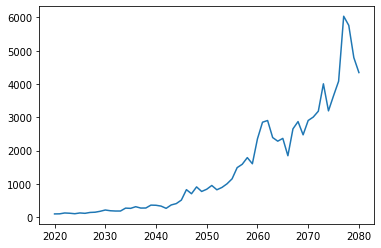

In [42]:
plt.plot(market['Price'])

## Combining with investment profile

In [142]:
inv_plan = pd.read_csv('investment_plan.csv', sep=';', index_col=0)
market['Price'] = market['Price']*100/market['Price'].iloc[0]

In [143]:
def calculate_return(inv, market, gearing_cap, pi):
    print(len(inv), len(market))
    assert len(inv) == len(market), 'Investment plan should be same no of periods as market' 
    
    total_savings = 'savings_contributions'.sum()
    r_f = 0.02
    
    
    
    columns = ['period', 'savings_contributions', 'contributions', 'roll_contributions', 'new_debt', 'total_debt', 'interest', 'total_exposure', 'portfolio_return', 'market_returns']
    
    inv['Market'] = market['Price']
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    inv['Roll_contribution'] = inv['Contributions'].cumsum()
    inv['Price'] = market['Price']
    inv['Account_value'] = 0
    inv['Total_debt'] = 0
    inv['New_debt'] = 0
    inv['Dollar_return'] = 0
    
    inv['Return'] = inv['Price'].pct_change()
    
    
    # Calculating debt
    for i in range(len(inv)):
        interest_rate = inv.iloc[i, 2]
        gearing = inv.iloc[i, 0]
        cont = inv.iloc[i, 1]
        new_debt = max(gearing-1, 0)*cont
        inv.iloc[i, 7] = new_debt
        
        # Calculating interest and total debt
        if i > 0:
            previous_debt = inv.iloc[i-1, 6]
            accrued_interest = previous_debt*(1+interest_rate)
        else:
            accrued_interest = 0
        
        total_debt = new_debt + accrued_interest
        inv.iloc[i, 6] = total_debt
    
        # Calculating total return
        if i == 0:
            account_value = new_debt + cont
        else:
            previous_account_value = inv.iloc[i-1, 5]
            period_return = inv.iloc[i, 9]
            account_value = (previous_account_value + (new_debt + cont))*(1+period_return)
        

        inv.iloc[i, 5] = account_value
        # Dollar return net debt
        inv.iloc[i, 8] = account_value - total_debt


    return inv

In [144]:
port = calculate_return(inv_plan, market)

61 61


<ipython-input-145-eceebd34809c>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale('log')


Text(0.5, 1.0, 'Portfolio contributions')

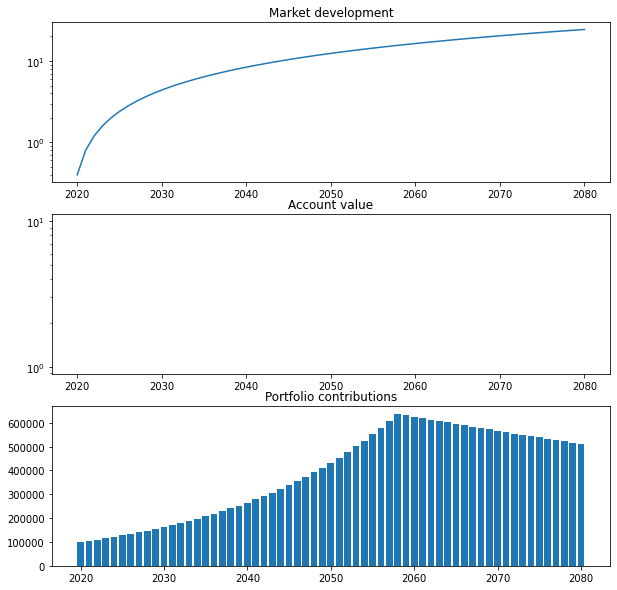

In [145]:
fig,ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(port['Price'])
ax[0].set_title('Market development')
ax[0].set_yscale('log')
ax[1].plot(port['Dollar_return'])
ax[1].set_title('Account value')
ax[1].set_yscale('log')
ax[2].bar(height=port['Contributions'], x=port.index)
ax[2].set_title('Portfolio contributions')